# Artificial Visual Imagination 
## Text to Image with BigGAN + CLIP + CMA-ES

---

BIGCLIP [j.mp/bigclip](https://j.mp/bigclip) by Eyal Gruss [@eyaler](https://twitter.com/eyaler) [eyalgruss.com](https://eyalgruss.com)


Modified to run on nautilus.optiputer.net by robert.twomey@gmail.com

# ~0. One-Time Setup~

(UPDATE: all of this has been moved to the docker image on gitlab 2021-02)

In [1]:
# !nvidia-smi -L

# import subprocess

# CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
# print("CUDA version:", CUDA_version)

# if CUDA_version == "10.0":
#     torch_version_suffix = "+cu101"
# #     torch_version_suffix = "+cu100"
# elif CUDA_version == "10.1":
#     torch_version_suffix = "+cu101"
# elif CUDA_version == "10.2":
#     torch_version_suffix = ""
# else:
#     torch_version_suffix = "+cu110"

# !pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

In [2]:
# !pip install pytorch-pretrained-biggan
# !pip install nltk
# !pip install cma

In [3]:
# !sudo apt-get install -y ffmpeg

Install code repo for CLIP:

In [4]:
# !git clone --depth 1 https://github.com/openai/CLIP

# 1. Imports to start session

Imports:

In [5]:
# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.WARNING)

from pytorch_pretrained_biggan import BigGAN
last_gen_model = 'biggan-deep-512'
biggan_model = BigGAN.from_pretrained(last_gen_model).cuda().eval()

100%|██████████| 800/800 [00:00<00:00, 480722.52B/s]


In [6]:
cd CLIP

/home/jovyan/work/visual-imagination/CLIP


In [7]:
import clip
last_clip_model = 'ViT-B/32'
perceptor, preprocess = clip.load(last_clip_model)

100%|███████████████████████| 353976522/353976522 [00:09<00:00, 37076494.57it/s]


In [8]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# 2. Config

In [9]:
prompt_set = [
    'sculpture television buddha',
    'television buddha sculpture with grass',
    'a buddha sculpture with television in the grass',
    'old television in grass with buddha sculpture by pacific ocean',
    'old television in long grass with buddha sculpture by pacific ocean'
]
prompt=prompt_set[4]

Edit your prompt below:

In [10]:
# prompt = 'television buddha sculpture with grass'
# prompt = 'a buddha sculpture with television in the grass'
# prompt = 'buddha television grass'
# prompt = "a clean well-lighted place"
# prompt = "large bright white room fluorescent light"
# prompt = "a room with good lighting"

gen_model = 'biggan-deep' #@param ['biggan-deep', 'sigmoid']
size = '512' #@param [512, 256, 128] 
color = True #@param {type:'boolean'}
initial_class = 'Random mix' #@param ['From prompt', 'Random class', 'Random Dirichlet', 'Random mix', 'Random embeddings'] {allow-input: true}
optimize_class = True #@param {type:'boolean'}
class_smoothing = 0.1 #@param {type:'number'}
truncation = 1 #@param {type:'number'}
stochastic_truncation = False #@param {type:'boolean'}
optimizer = 'CMA-ES' #@param ['SGD','Adam','CMA-ES','CMA-ES+SGD','CMA-ES+Adam']
pop_size = 50 #@param {type:'integer'}
clip_model = 'ViT-B/32' #@param ['ViT-B/32','RN50']
augmentations =  64#@param {type:'integer'}
learning_rate =  0.1#@param {type:'number'}
standartization_loss =  0#@param {type:'number'}
minimum_entropy_loss = 0.0001 #@param {type:'number'}
embeddings_l2_loss = 0.0001 #@param {type:'number'}
total_variation_loss = 0.1 #@param {type:'number'}
iterations = 50 #@param {type:'integer'}
save_every = 1 #@param {type:'integer'}
fps = 1 #@param {type:'number'}
freeze_secs = 0 #@param {type:'number'}

# seed =  0#@param {type:'number'}
seed = 1

# 3. Generate

In [11]:

# make a fresh output directory

outpath = "/home/jovyan/work/output/"
!rm -rf $outpath
!mkdir -p $outpath


#@title Generate!
#@markdown 1. For **prompt** OpenAI suggest to use the template "A photo of a X." or "A photo of a X, a type of Y." [[paper]](https://cdn.openai.com/papers/Learning_Transferable_Visual_Models_From_Natural_Language_Supervision.pdf)
#@markdown 2. For **initial_class** you can either use free text or select a special option from the drop-down list.
#@markdown 3. Free text and 'From prompt' might fail to find an appropriate ImageNet class.
#@markdown 4. **seed**=0 means no seed.

if seed == 0:
  seed = None
noise_size = 128
class_size = 128 if initial_class.lower()=='random embeddings' else 1000
channels = 3 if color else 1
clip_res = perceptor.input_resolution.item()
gen_model = gen_model + '-' + size
sideX = sideY = int(size)
if sideX<=clip_res and sideY<=clip_res:
  augmentations = 1
if 'CMA' not in optimizer:
  pop_size = 1
if gen_model != last_gen_model and 'biggan' in gen_model:
  biggan_model = BigGAN.from_pretrained(gen_model).cuda().eval()
  last_gen_model = gen_model
if clip_model != last_clip_model:
  perceptor, preprocess = clip.load(clip_model)
  last_clip_model = clip_model
if 'sigmoid' in gen_model:
  optimize_class = False
emb_factor = 0.005

def my_forward(self, z, class_label, truncation):
  assert 0 < truncation <= 1

  if initial_class.lower()=='random embeddings':
    embed = class_label
  else:
    embed = self.embeddings(class_label)
    
#   print(z, embed, truncation)
  cond_vector = torch.cat((z, embed), dim=1)

  z = self.generator(cond_vector, truncation)
  return z

BigGAN.forward = my_forward


import numpy as np
state = None if not seed else np.random.RandomState(seed)
np.random.seed(seed)
import torch
import torchvision
import sys
# torch.manual_seed(np.random.randint(sys.maxsize))
torch.manual_seed(seed)
import imageio
from IPython.display import HTML, Image, clear_output
from scipy.stats import truncnorm, dirichlet
from pytorch_pretrained_biggan import BigGAN, convert_to_images, one_hot_from_names, utils
from nltk.corpus import wordnet as wn
from base64 import b64encode
from time import time
import cma
from cma.sigma_adaptation import CMAAdaptSigmaCSA, CMAAdaptSigmaTPA
import warnings
warnings.simplefilter("ignore", cma.evolution_strategy.InjectionWarning)

ind2name = {index: wn.of2ss('%08dn'%offset).lemma_names()[0] for offset, index in utils.IMAGENET.items()}

def save(out,name):
  with torch.no_grad():
    out = out.cpu().numpy()
  if 'sigmoid' in gen_model:
    out = out*2 - 1
  img = convert_to_images(out)[0] # saves the first image
  imageio.imwrite(name, np.asarray(img))

def save_vec(out,name):
  with torch.no_grad():
    vec = out.cpu().numpy()
  np.savetxt(name, vec)

def save_all_vecs(out, name):
  with torch.no_grad():
    vec = out.cpu().numpy()
  np.savetxt(name, vec)
    
def checkin(i, best_ind, total_losses, losses, regs, out, probs=None):
  global sample_num
  name = outpath+'frame_%05d.jpg'%sample_num
  save(out, name)
  clear_output()
  display(Image(name))  
  stats = 'sample=%d iter=%d best: total=%.2f cos=%.2f reg=%.3f avg: total=%.2f cos=%.2f reg=%.3f std: total=%.2f cos=%.2f reg=%.3f'%(sample_num, i, total_losses[best_ind], losses[best_ind], regs[best_ind], np.mean(total_losses), np.mean(losses), np.mean(regs), np.std(total_losses), np.std(losses), np.std(regs))
  
  if probs is not None:
    best = probs[best_ind]
    inds = np.argsort(best)[::-1]
    probs = np.array(probs)
    stats += ' 1st=%s(%.2f) 2nd=%s(%.2f) 3rd=%s(%.2f) components: >=0.5:%.0f, >=0.3:%.0f, >=0.1:%.0f'%(ind2name[inds[0]], best[inds[0]], ind2name[inds[1]], best[inds[1]], ind2name[inds[2]], best[inds[2]], np.sum(probs >= 0.5)/pop_size,np.sum(probs >= 0.3)/pop_size,np.sum(probs >= 0.1)/pop_size)
  print(stats)
  print('Best index: %s' % best_ind)
  # save best vectors
  save_vec(noise_vector[best_ind], outpath+'noise_%05d.txt'%sample_num) # saves the first vectors
  save_vec(class_vector[best_ind], outpath+'class_%05d.txt'%sample_num)  
  # save all vectors
#   save_vec(noise_vector, outpath+'all_noise_%05d.txt'%sample_num) # saves the first vectors
#   save_vec(class_vector, outpath+'all_class_%05d.txt'%sample_num)  
  sample_num += 1

def get_output(noise_vector, class_vector):
  if stochastic_truncation:
    with torch.no_grad():
      trunc_indices = noise_vector.abs() > 2*truncation
      size = torch.count_nonzero(trunc_indices).cpu().numpy()
      trunc = truncnorm.rvs(-2*truncation, 2*truncation, size=(1,size)).astype(np.float32)
      noise_vector.data[trunc_indices] = torch.tensor(trunc, requires_grad='SGD' in optimizer or 'Adam' in optimizer, device='cuda')
  else:
    noise_vector = noise_vector.clamp(-2*truncation, 2*truncation)
  
  if initial_class.lower() == 'random embeddings':
    class_vector_norm = class_vector*emb_factor
  else:
    class_vector_norm = class_vector.softmax(dim=-1)
  
  return biggan_model(noise_vector, class_vector_norm, truncation), class_vector_norm

def ascend_txt(i, grad_step=False, show_save=False):
  prev_class_vector_norms = []
  regs = []
  losses = []
  total_losses = []
  best_loss = np.inf

  for j in range(pop_size):
    p_s = []
    
    if 'sigmoid' in gen_model:
      out = noise_vector[j:j+1].sigmoid().reshape(1, channels, sideY, sideX)
      prev_class_vector_norms = None
    else:
      out, class_vector_norm = get_output(noise_vector[j:j+1], class_vector[j:j+1])
      if channels==1:
        out = out.mean(dim=1, keepdim=True)
      if initial_class.lower() == 'random embeddings':
        prev_class_vector_norms = None
      else:
        with torch.no_grad():
          prev_class_vector_norms.append(class_vector_norm.cpu().numpy()[0])
    
    if channels==1:
      out = out.repeat(1,3,1,1)
    
    for aug in range(augmentations):
      if sideX<=clip_res and sideY<=clip_res:
        apper = out  
      else:
        size = torch.randint(int(.5*sideX), int(.98*sideX), ())
        #size = int(sideX*torch.zeros(1,).normal_(mean=.8, std=.3).clip(.5, .95))
        offsetx = torch.randint(0, sideX - size, ())
        offsety = torch.randint(0, sideX - size, ())
        apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
        apper = (apper+1)/2
      apper = torch.nn.functional.interpolate(apper, clip_res, mode='bicubic')
      apper = apper.clamp(0,1)
      p_s.append(apper)
    
    into = nom(torch.cat(p_s, 0))
    predict_clip = perceptor.encode_image(into)
    factor = 100
    loss = factor*(1-torch.cosine_similarity(predict_clip, target_clip).mean())
    total_loss = loss
    
    if 'sigmoid' in gen_model and total_variation_loss or 'biggan' in gen_model and (standartization_loss or optimize_class and (initial_class.lower() != 'random embeddings' and minimum_entropy_loss or  initial_class.lower() == 'random embeddings' and embeddings_l2_loss)):
      reg = 0
      if 'sigmoid' in gen_model:
        if total_variation_loss:
          reg += total_variation_loss*((out[:, :, :-1, :] - out[:, :, 1:, :]).abs().mean() + (out[:, :, :, :-1] - out[:, :, :, 1:]).abs().mean())
      elif 'biggan' in gen_model:
        if minimum_entropy_loss and initial_class.lower() != 'random embeddings':
          reg += minimum_entropy_loss*((-class_vector_norm*torch.log(class_vector_norm+eps)).sum()-smoothed_ent).abs()
        elif embeddings_l2_loss and initial_class.lower() == 'random embeddings':
          reg += embeddings_l2_loss*class_vector_norm.square().sum()
        if standartization_loss: #https://arxiv.org/abs/1903.00925
          mu2 = noise_vector[j:j+1].mean().square()
          sigma2 = noise_vector[j:j+1].std().square()
          reg += standartization_loss*(mu2+sigma2-torch.log(sigma2))
      reg = factor*reg
      total_loss = total_loss + reg
      with torch.no_grad():
        regs.append(reg.item())
    else:
      regs.append(0)
    
    # store losses
    with torch.no_grad():
      losses.append(loss.item())
      total_losses.append(total_loss.item())
        
    if total_losses[-1]<best_loss:
      best_loss = total_losses[-1]
      best_ind = j
      best_out = out
    
    if grad_step:    
      optim.zero_grad()
      total_loss.backward()
      optim.step()
      
  if show_save and (i == iterations-1 or i % save_every == 0):
    if i==iterations-1:
      save(best_out,'%s.jpg'%prompt)
      save_vec(noise_vector[best_ind], 'noise_%s.txt'%prompt)
      save_vec(class_vector[best_ind], 'class_%s.txt'%prompt)
    if i % save_every == 0:
      checkin(i, best_ind, total_losses, losses, regs, best_out, prev_class_vector_norms)  
  return total_losses

Actual training loops:

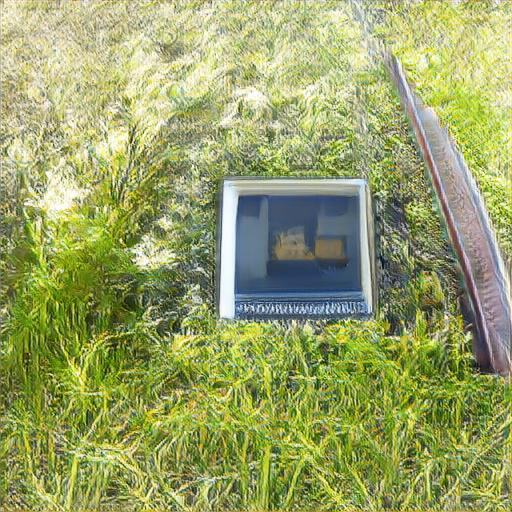

sample=49 iter=49 best: total=62.79 cos=62.78 reg=0.008 avg: total=68.99 cos=68.98 reg=0.008 std: total=3.46 cos=3.46 reg=0.003 1st=crate(0.94) 2nd=prayer_rug(0.05) 3rd=pillow(0.00) components: >=0.5:1, >=0.3:1, >=0.1:1
Best index: 47
took: 296 secs (5.92 sec/iter) on GPU 0: GeForce RTX 2080 Ti (UUID: GPU-f4974f5e-abbd-511c-1676-bc6d9392225f)


In [12]:

eps = 1e-8
if 'sigmoid' in gen_model:
  noise_size = channels*sideY*sideX
  noise_vector = np.random.rand(pop_size, noise_size).astype(np.float32)
  noise_vector = np.log((noise_vector+eps)/(1-noise_vector+eps))
else:
  noise_vector = truncnorm.rvs(-2*truncation, 2*truncation, size=(pop_size, noise_size), random_state=state).astype(np.float32) #see https://github.com/tensorflow/hub/issues/214

  if initial_class.lower() == 'random class':
    class_vector = np.ones(shape=(pop_size, class_size), dtype=np.float32)*class_smoothing/999
    class_vector[0,np.random.randint(class_size)] = 1-class_smoothing
  elif initial_class.lower() == 'random dirichlet':
    class_vector = dirichlet.rvs([pop_size/class_size] * class_size, size=1, random_state=state).astype(np.float32)
  elif initial_class.lower() == 'random mix':
    class_vector = np.random.rand(pop_size, class_size).astype(np.float32)
  elif initial_class.lower() == 'random embeddings':
    class_vector = np.random.randn(pop_size, class_size).astype(np.float32)
  else:
    if initial_class.lower() == 'from prompt':
      initial_class = prompt
    try:
      class_vector = None
      class_vector = one_hot_from_names(initial_class, batch_size=pop_size)
      assert class_vector is not None
      class_vector = class_vector*(1-class_smoothing*class_size/(class_size-1))+class_smoothing/(class_size-1)
    except Exception as e:  
      print('Error: could not find initial_class. Try something else.')
      raise e

  if initial_class.lower() != 'random embeddings':
    class_vector = class_vector/np.sum(class_vector,axis=-1, keepdims=True)
    class_vector = np.log(class_vector+eps)
  initial_class_vector = class_vector[0]
  if initial_class.lower() == 'random mix':
    initial_class_vector = initial_class_vector*0-np.log(class_size)
  if initial_class.lower() == 'random embeddings':
    initial_class_vector = initial_class_vector*0
  class_vector = torch.tensor(class_vector, requires_grad='SGD' in optimizer or 'Adam' in optimizer, device='cuda')
  smoothed_ent = -torch.tensor(class_smoothing*np.log(class_smoothing/999+eps)+(1-class_smoothing)*np.log(1-class_smoothing+eps), dtype=torch.float32).cuda()
noise_vector = torch.tensor(noise_vector, requires_grad='SGD' in optimizer or 'Adam' in optimizer, device='cuda')

if 'SGD' in optimizer or 'Adam' in optimizer:
  params = [noise_vector]
  if optimize_class:
    params = params + [class_vector]
  if 'SGD' in optimizer:
    optim = torch.optim.SGD(params, lr=learning_rate, momentum=0.9)  
  else:
    optim = torch.optim.Adam(params, lr=learning_rate)

tx = clip.tokenize(prompt)
with torch.no_grad():
  target_clip = perceptor.encode_text(tx.cuda())

nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
if 'CMA' in optimizer:
  initial_vector = np.zeros(noise_size)
  bounds = None
  #if 'sigmoid' not in gen_model and not stochastic_truncation:
  #  bounds = [-2*truncation*np.ones(noise_size),2*truncation*np.ones(noise_size)]
  if optimize_class:
    initial_vector = np.hstack([initial_vector, initial_class_vector])
    #if not stochastic_truncation:
    #  bounds[0] = list(bounds[0]) + [None]*class_size
    #  bounds[1] = list(bounds[1]) + [None]*class_size
  cma_opts = {'popsize': pop_size, 'seed': np.nan, 'AdaptSigma': True, 'CMA_diagonal': True, 'CMA_active': False, 'CMA_elitist':False, 'bounds':bounds}
  cmaes = cma.CMAEvolutionStrategy(initial_vector, 1, inopts=cma_opts)

sample_num = 0
machine = !nvidia-smi -L
start = time()
for i in range(iterations):    
  if 'CMA' in optimizer:
    with torch.no_grad():
      cma_results = torch.tensor(cmaes.ask(), dtype=torch.float32).cuda()
      if optimize_class:
        noise_vector.data, class_vector.data = torch.split_with_sizes(cma_results, (noise_size, class_size), dim=-1)
        class_vector.data = class_vector.data
      else:
        noise_vector.data = cma_results      
  if 'SGD' in optimizer or 'Adam' in optimizer:
    losses = ascend_txt(i, grad_step=True, show_save='CMA' not in optimizer)
    assert noise_vector.requires_grad and noise_vector.is_leaf and (not optimize_class or class_vector.requires_grad and class_vector.is_leaf), (noise_vector.requires_grad, noise_vector.is_leaf, class_vector.requires_grad, class_vector.is_leaf)
  if 'CMA' in optimizer:
    with torch.no_grad():
      losses = ascend_txt(i, show_save=True)
      if optimize_class:
        vectors = torch.cat([noise_vector,class_vector], dim=1)
      else:
        vectors = noise_vector
      cmaes.tell(vectors.cpu().numpy(), losses)
  if i == iterations-1 or i % save_every == 0:
    print('took: %d secs (%.2f sec/iter) on %s'%(time()-start,(time()-start)/(i+1), machine[0]))

Move output to datestamped folder: 

In [13]:
# move to datestamped path
import os, datetime
newdir = outpath[:-1]+"_"+datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
!mv $outpath $newdir
!mkdir -p $outpath

# 4. Create Video

In [14]:
# cd $outpath

In [15]:
# pwd

In [16]:
# # generate mp4
# out = '%s.mp4'%prompt.replace(" ", "_")
# with open('list.txt','w') as f:
#   for i in range(sample_num):
#     f.write('file frame_%05d.jpg\n'%i)
#   for j in range(int(freeze_secs*fps)):
#     f.write('file frame_%05d.jpg\n'%i)
# !ffmpeg -r $fps -f concat -safe 0 -i list.txt -c:v libx264 -pix_fmt yuv420p -profile:v baseline -movflags +faststart -r $fps $out -y

# # rename jpg
# frame = 'frame_%05d.jpg'%(sample_num-1)
# jpg = '%s.jpg'%prompt.replace(" ", "_")
# !cp $frame $jpg

In [17]:
# # move to datestamped path
# import os, datetime
# newdir = outpath[:-1]+"_"+datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
# !mv $outpath $newdir
# !mkdir -p $outpath

In [18]:
# from IPython.display import display, FileLink, FileLinks

# local_file = FileLink(out.replace('"', ""), result_html_prefix="Click here to download: ")
# # local_file = FileLinks(".", result_html_suffix="?download")
# display(local_file)

In [19]:
# from IPython.display import HTML
# local_file = out.replace('"', "")
# HTML("<a href=\""+local_file+"\">download %s</a>"%local_file)

# Notes


Based on SIREN+CLIP Colabs by: [@advadnoun](https://twitter.com/advadnoun), [@norod78](https://twitter.com/norod78)

Other CLIP notebooks: [OpenAI tutorial](https://colab.research.google.com/github/openai/clip/blob/master/Interacting_with_CLIP.ipynb), [SIREN by @advadnoun](https://colab.research.google.com/drive/1FoHdqoqKntliaQKnMoNs3yn5EALqWtvP), [SIREN by @norod78](https://colab.research.google.com/drive/1K1vfpTEvAmxW2rnhAaALRVyis8EiLOnD), [BigGAN by @advadnoun](https://colab.research.google.com/drive/1NCceX2mbiKOSlAd_o7IU7nA9UskKN5WR), [BigGAN by @eyaler](j.mp/bigclip), [BigGAN by @tg_bomze](https://colab.research.google.com/github/tg-bomze/collection-of-notebooks/blob/master/Text2Image_v2.ipynb), [BigGAN using big-sleep library by @lucidrains](https://colab.research.google.com/drive/1MEWKbm-driRNF8PrU7ogS5o3se-ePyPb), [BigGAN story hallucinator by @bonkerfield](https://colab.research.google.com/drive/1jF8pyZ7uaNYbk9ZiVdxTOajkp8kbmkLK), [StyleGAN2-ADA Anime by @nagolinc](https://colab.research.google.com/github/nagolinc/notebooks/blob/main/TADNE_and_CLIP.ipynb) [v2](https://colab.research.google.com/github/nagolinc/notebooks/blob/main/CLIP_%2B_TADNE_(pytorch)_v2.ipynb)

Using the works:

https://github.com/openai/CLIP

https://tfhub.dev/deepmind/biggan-deep-512

https://github.com/huggingface/pytorch-pretrained-BigGAN

http://www.aiartonline.com/design-2019/eyal-gruss (WanderGAN)

For a curated list of more online generative tools see: [j.mp/generativetools](https://j.mp/generativetools)
